In [ ]:
pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 97.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.

**MULAI DARISINI**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [40]:
from google.colab import drive
drive.mount('/content/drive')

# Path ke file CSV di Google Drive
path = '/content/drive/My Drive/Tugas_Kuliah/Tugas Akhir/data_harga.csv'

# Baca file CSV (otomatis deteksi delimiter jika mungkin ada koma atau titik koma)
df = pd.read_csv(path)

# Pastikan jumlah kolom sesuai
print("Kolom tersedia:", df.columns.tolist())

# Cek apakah perlu rename kolom
if len(df.columns) == 2:
    df.columns = ['tgl', 'harga']
else:
    # Jika kolom hanya 1 (misalnya karena pemisah salah), coba lagi pakai delimiter eksplisit
    df = pd.read_csv(path, sep=';')
    df.columns = ['tgl', 'harga']

# Bersihkan spasi dan karakter non-digit dari harga (jika ada)
df['harga'] = df['harga'].astype(str).str.replace('.', '', regex=False).str.replace(',', '', regex=False).str.strip()

# Konversi kolom 'harga' ke numeric
df['harga'] = pd.to_numeric(df['harga'], errors='coerce')

# Konversi kolom 'tgl' ke datetime dengan format '%m-%Y'
df['tgl'] = pd.to_datetime(df['tgl'], format='%m-%Y', errors='coerce')

# Hapus baris dengan data tidak valid (jika ada)
df.dropna(subset=['tgl', 'harga'], inplace=True)

# Jadikan 'tgl' sebagai index dan atur frekuensi bulanan
df.set_index('tgl', inplace=True)
df = df.asfreq('MS')

# Tampilkan hasil
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Kolom tersedia: ['tgl', 'harga']
            harga
tgl              
2010-01-01   6702
2010-02-01   6888
2010-03-01   6854
2010-04-01   6761
2010-05-01   6772


In [41]:
# Urutkan berdasarkan tanggal
df.sort_index(inplace=True)

# Bagi data menjadi train dan test
train_size = len(df) - 12  # 5 bulan
df_train = df.iloc[:train_size].copy()
df_test = df.iloc[train_size:].copy()

print("Jumlah data train:", len(df_train))
print("Jumlah data test:", len(df_test))

Jumlah data train: 174
Jumlah data test: 12


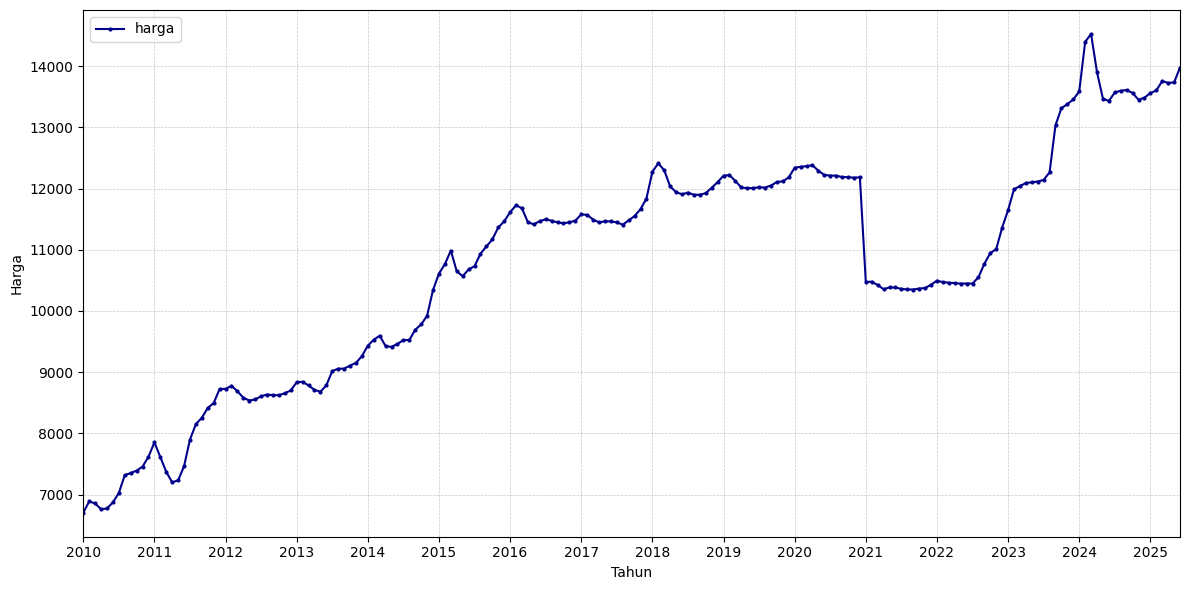

In [32]:
import matplotlib.pyplot as plt

# Pastikan index dalam datetime dan berfrekuensi bulanan
df = df.asfreq('MS')

# Buat plot
fig, ax = plt.subplots(figsize=(12, 6))
df.plot(ax=ax, marker='o', markersize=2, color='darkblue',)
ax.set_xlabel("Tahun")
ax.set_ylabel("Harga")

# Atur label hanya di Januari (satu kali per tahun)
ticks = df[df.index.month == 1].index
ax.set_xticks(ticks)
ax.set_xticklabels([t.strftime('%Y') for t in ticks], rotation=0)

# Tambahkan garis grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


In [33]:
# Cek adfuller
result = adfuller(df.harga.dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.255771
p-value: 0.649157


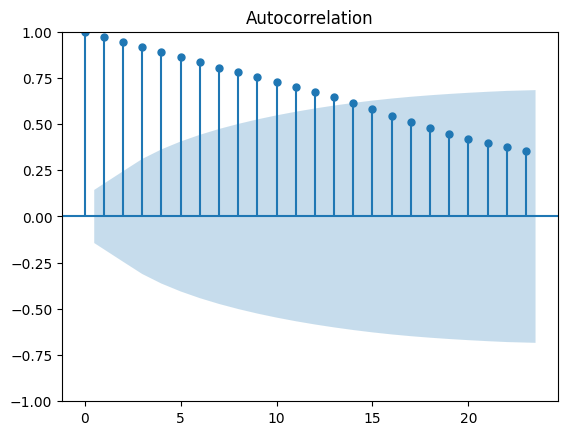

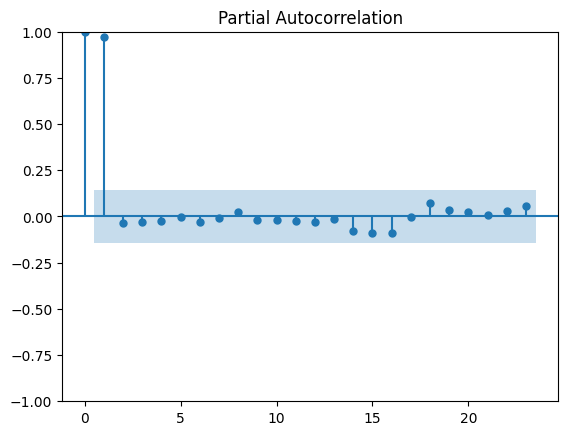

In [23]:
#cek adf pacf belum di diferencing
acf_original = plot_acf(df.harga)
pacf_original = plot_pacf(df.harga)


<Axes: xlabel='tgl'>

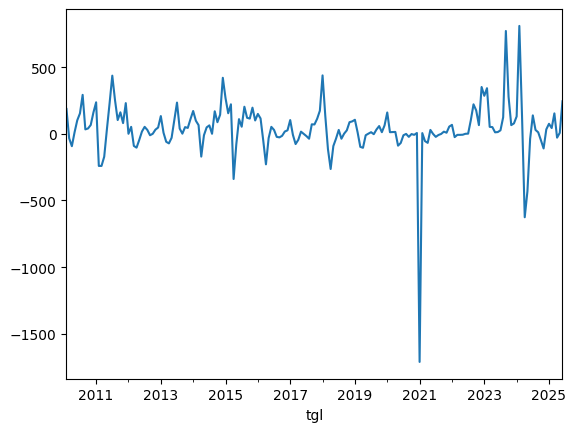

In [34]:
#diferencing 1
df_harga_diff = df.harga.diff().dropna()
df_harga_diff.plot()

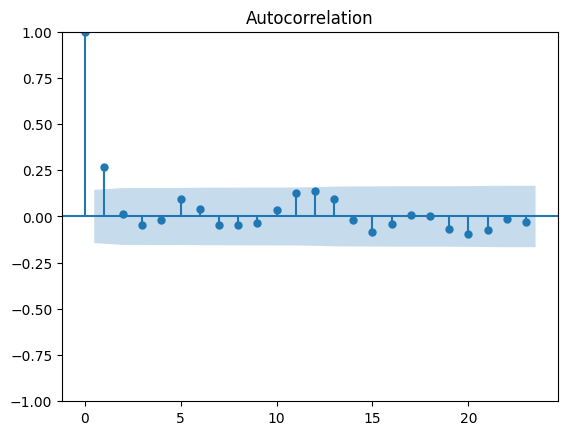

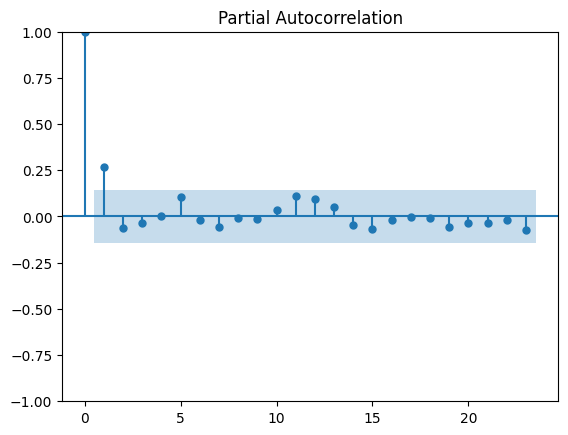

In [35]:
#cek acf dan pacf yang sudah di differencing
acf_diff = plot_acf(df_harga_diff)

pacf_diff = plot_pacf(df_harga_diff)

In [42]:
#membuat model arima
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train['harga'], order=(1,1,1), trend='t')
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  harga   No. Observations:                  174
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1159.648
Date:                Wed, 10 Sep 2025   AIC                           2327.295
Time:                        09:15:47   BIC                           2339.908
Sample:                    01-01-2010   HQIC                          2332.412
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            38.8000     25.037      1.550      0.121     -10.272      87.872
ar.L1          0.1169      0.235      0.498      0.619      -0.344       0.577
ma.L1          0.1698      0.233      0.729      0.4

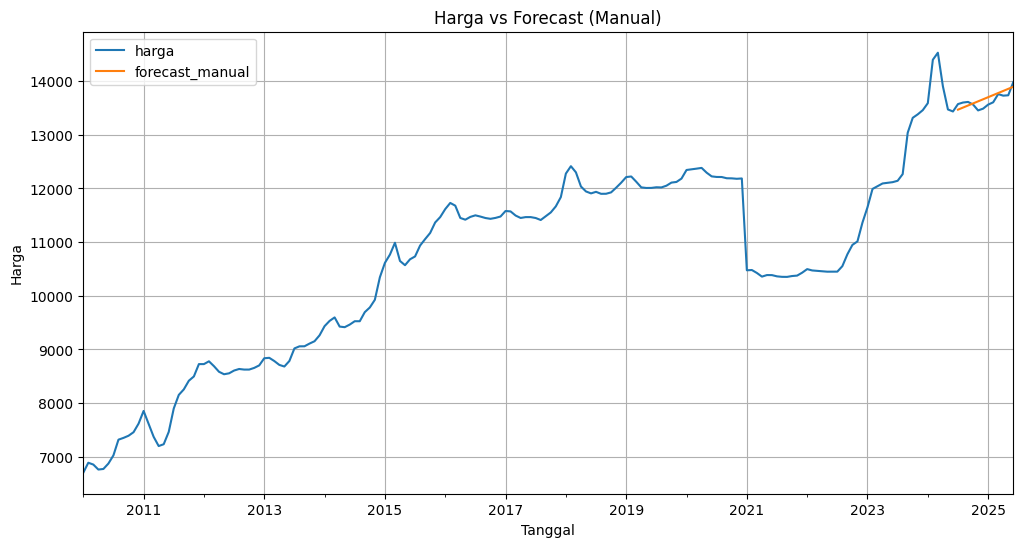

In [43]:
# Prediksi sebanyak panjang data test
forecast_test = model_fit.forecast(steps=len(df_test))

# Tambahkan hasil prediksi ke df (pastikan forecast disimpan di waktu yang benar)
df['forecast_manual'] = None
df.loc[df_test.index, 'forecast_manual'] = forecast_test.values

# Plot hasilnya
df[['harga', 'forecast_manual']].plot(figsize=(12,6))
plt.title("Harga vs Forecast (Manual)")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.grid(True)
plt.show()

In [44]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 101.17595403189216
mape - manual: 0.007435475176814564
rmse - manual: 111.97182280261558


2025-02-01    13613.093408
2025-03-01    13653.623742
2025-04-01    13691.063901
2025-05-01    13728.447515
2025-06-01    13766.237062
Freq: MS, Name: predicted_mean, dtype: float64
     Tanggal  Prediksi_Harga
0 2025-02-28    13613.093408
1 2025-03-31    13653.623742
2 2025-04-30    13691.063901
3 2025-05-31    13728.447515
4 2025-06-30    13766.237062


/tmp/ipython-input-1780101662.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=last_index, periods=5+1, freq='M')[1:]
/tmp/ipython-input-1780101662.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=last_index, periods=5+1, freq='M')[1:]


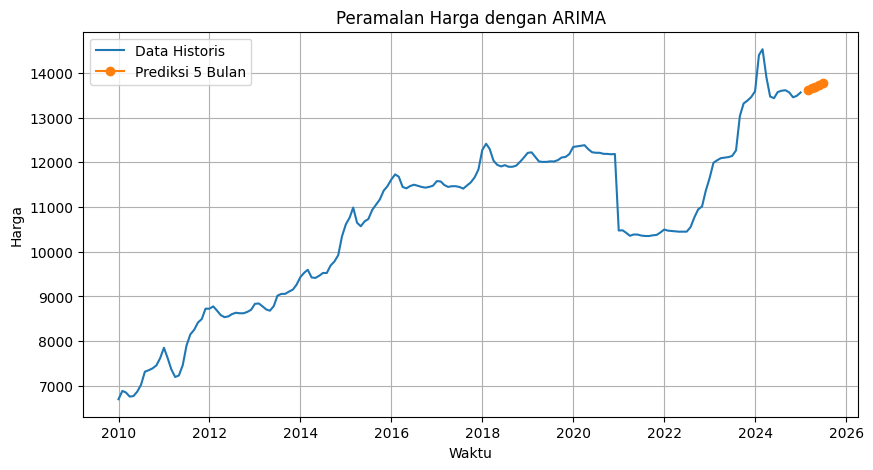

In [39]:
# Prediksi 5 bulan ke depan
forecast = model_fit.forecast(steps=5)
print(forecast)

# Ambil index terakhir dari data train
last_index = df_train.index[-1]

# Buat index waktu untuk 5 bulan ke depan
future_index = pd.date_range(start=last_index, periods=5+1, freq='M')[1:]

# Simpan hasil prediksi ke DataFrame
forecast_df = pd.DataFrame({
    'Tanggal': future_index,
    'Prediksi_Harga': forecast.values
})

print(forecast_df)

# Prediksi 5 bulan ke depan
forecast = model_fit.forecast(steps=5)

# Buat index waktu untuk 5 bulan ke depan
last_index = df_train.index[-1]
future_index = pd.date_range(start=last_index, periods=5+1, freq='M')[1:]

# Plot data historis
plt.figure(figsize=(10,5))
plt.plot(df_train.index, df_train['harga'], label='Data Historis')

# Plot hasil prediksi
plt.plot(future_index, forecast, label='Prediksi 5 Bulan', marker='o')

plt.xlabel('Waktu')
plt.ylabel('Harga')
plt.title('Peramalan Harga dengan ARIMA')
plt.legend()
plt.grid(True)
plt.show()


**SELESAI**

In [ ]:
#tes pvalue setelah di diferencing
adf_test = adfuller(df_harga_diff)
print(f'p-value: {adf_test[1]}')

p-value: 4.925827903314938e-18


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Buat model SARIMA (dengan nama variabel berbeda)
sarima_model = SARIMAX(df_train['harga'],
                       order=(0, 1, 1),              # Komponen non-musiman
                       seasonal_order=(0, 1, 1, 12), # Komponen musiman: tahunan (s=12)
                       trend='t',
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit model
sarima_result = sarima_model.fit()

# Cetak ringkasan hasil
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              harga   No. Observations:                  170
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -966.789
Date:                            Mon, 16 Jun 2025   AIC                           1941.578
Time:                                    18:07:11   BIC                           1953.429
Sample:                                01-01-2010   HQIC                          1946.393
                                     - 02-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0465      0.061      0.760      0.447      -0.073       0.166
ma.L1          0.2195      0.060   

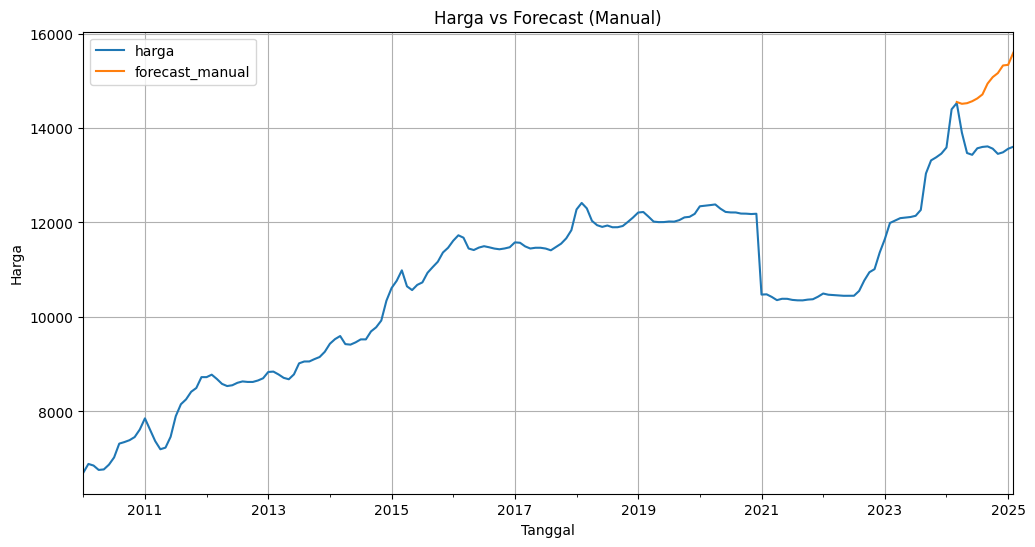

In [ ]:
# Prediksi sebanyak panjang data test
forecast_test2 = sarima_result.forecast(steps=len(df_test))

# Tambahkan hasil prediksi ke df (pastikan forecast disimpan di waktu yang benar)
df['forecast_manual'] = None
df.loc[df_test.index, 'forecast_manual'] = forecast_test2.values

# Plot hasilnya
df[['harga', 'forecast_manual']].plot(figsize=(12,6))
plt.title("Harga vs Forecast (Manual)")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(df_test, forecast_test2)
mape = mean_absolute_percentage_error(df_test, forecast_test2)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test2))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 1262.6545082832438
mape - manual: 0.09317019686219986
rmse - manual: 1372.7032656528222


In [ ]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.3 MB/s eta 0:00:00


In [12]:
import pmdarima as pm
import matplotlib.pyplot as plt

# Pastikan df_train hanya berisi angka (seri waktu harga saja)
y_train = df_train['harga']
y_test = df_test['harga']

# Mencari model ARIMA terbaik
model_auto = pm.auto_arima(
    y_train,
    seasonal=False,          # Non-seasonal ARIMA
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

# Tampilkan ringkasan model
print(model_auto.summary())

# Lakukan prediksi ke depan sebanyak panjang df_test
n_periods = len(y_test)
forecast = model_auto.predict(n_periods=n_periods)

# Buat DataFrame gabungan untuk visualisasi
forecast_index = y_test.index
df_result = df_train.copy()
df_result = pd.concat([
    df_result,
    pd.DataFrame({'harga': [None]*n_periods}, index=forecast_index)
])

df_result['forecast_arima'] = list([None]*len(df_train)) + list(forecast)

# Visualisasikan
plt.figure(figsize=(12,5))
plt.plot(df_result.index, df_result['harga'], label='Data Aktual')
plt.plot(df_result.index, df_result['forecast_arima'], label='Prediksi ARIMA', color='red', linestyle='--')
plt.title('Prediksi ARIMA pada Data Test')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'pmdarima'

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Pastikan panjang prediksi sama dengan data aktual
forecast = np.array(forecast)
actual = np.array(y_test)

# Hitung MAE
mae = mean_absolute_error(actual, forecast)

# Hitung RMSE
rmse = np.sqrt(mean_squared_error(actual, forecast))

# Hitung MAPE (hindari pembagian dengan nol)
mape = np.mean(np.abs((actual - forecast) / actual)) * 100

# Tampilkan hasil evaluasi
print(f"MAE  (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")


MAE  (Mean Absolute Error): 1817.61
RMSE (Root Mean Squared Error): 2080.92
MAPE (Mean Absolute Percentage Error): 16.16%
